# `Асинхронное программирование`

## Исполнение кода в одном потоке, модуль select


In [ ]:
# Неблокирующий ввод/вывод, обучающий пример

import socket
import select

sock = socket.socket()
sock.bind(("", 10001))
sock.listen()

# как обработать запросы для conn1 and conn2
# одновременно без потока?
conn1, addr = sock.accept()
conn2, addr = sock.accept()

conn1.setblocking(0)
conn2.setblocking(0)

epoll = select.epoll()
epoll.register(conn1.fileno(), select.EPOLLIN | select.EPOLLOUT)
epoll.register(conn12.fileno(), select.EPOLLIN | select.EPOLLOUT)

conn_map = {
    conn1.fileno(): conn1,
    conn2.fileno(): conn2
}

In [ ]:
# Неблокирующий ввод/вывод, обучающий пример
# Цикл обработки событий в epoll

while True:
    events = epoll.poll(1)
    for fileno, event in events:
        if event & select.EPOLLIN:
            # обработка чтения из сокета
            data=conn_map[fileno].recv(1024)
            print(data.decode("utf8"))
        elif event & select.EPOLLOUT:
            # обработка записи в сокет
            conn_map[fileno].send("pong".encode("utf8"))

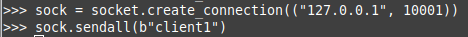
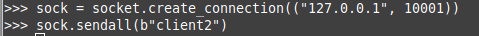
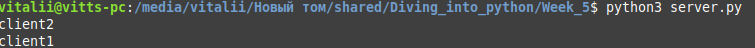

## Итераторы и генераторы, в чём разница?

In [22]:
# Итераторы

class MyRangeIterators:
    def __init__(self, top):
        self.top = top
        self.current = 0
    def __iter__(self):
        return self
    def __next__(self):
        if self.current >= self.top:
            raise StopIteration
            
        current = self.current
        self.current += 1
        return current

In [23]:
counter = MyRangeIterators(3)

In [24]:
counter

In [25]:
for it in counter:
    print(it)

0
1
2


In [26]:
# Генераторы

def MyRangeGenerator(top):
    current = 0
    while current < top:
        yield current
        current += 1

In [27]:
counter = MyRangeGenerator(3)
counter

<generator object MyRangeGenerator at 0x7f529d1a5040>

In [28]:
for it in counter:
    print(it)

0
1
2


## Генераторы и сопрограммы

In [29]:
# Сопрограммы (корутины)

def grep(pattern):
    print("start grep")
    while True:
        line = yield
        if pattern in line:
            print(line)
g = grep("python3")

In [30]:
next(g) # g.send(None)

start grep


In [31]:
g.send("golang is better?")
g.send("python3 is simple!")

python3 is simple!


In [41]:
# Сопрограммы , вызов метода close()

def grep(pattern):
    print("start grep")
    try:
        while True:
            line = yield 
            if pattern in line:
                print(line)
    except GeneratorExit:
        print("stop grep")
g = grep("red")

In [42]:
next(g) # g.send(None)

start grep


In [43]:
g.send("red color")

red color


In [44]:
g.close()

stop grep


In [46]:
# Сопрограммы , генерация исключений

def grep(pattern):
    print("start grep")
    try:
        while True:
            line = yield 
            if pattern in line:
                print(line)
    except GeneratorExit:
        print("stop grep")
g = grep("python")
g.send(None) # next(g)

start grep


In [47]:
g.send("python is the best!")

python is the best!


In [48]:
g.throw(RuntimeError, "something wrong")

RuntimeError: something wrong

In [49]:
# Вызов сопрограмм,  PEP 380

def grep(pattern):
    print("start grep")
    while True:
        line = yield 
        if pattern in line:
            print(line)
def grep_python_coroutine():
    g = grep("python")
    next(g)
    g.send("python is the best!")
    g.close()

In [50]:
g = grep_python_coroutine() # is g coroutine? no

start grep
python is the best!


In [51]:
g

In [57]:
# Сопрограммы, yield from PEP 0380

def grep(pattern):
    print("start grep")
    while True:
        line = yield 
        if pattern in line:
            print(line)

def grep_python_coroutine():
    g = grep("python")
    yield from g

In [58]:
g = grep_python_coroutine() # is g coroutine? yes

In [59]:
g

<generator object grep_python_coroutine at 0x7f529cee5660>

In [61]:
g.send(None)
g.send("python wow!")

start grep
python wow!


In [62]:
# PEP 380, генераторы

def chain(x_iterable, y_iterable):
    yield from x_iterable
    yield from y_iterable

def the_same_chain(x_iterable, y_iterable):
    for x in x_iterable:
        yield x
    
    for y in y_iterable:
        yield y

In [65]:
a = [1, 2, 3]
b = (4, 5)
print(type(a), type(b))

<class 'list'> <class 'tuple'>


In [66]:
for x in chain(a, b):
    print(x, end=',')

1,2,3,4,5,

In [67]:
for x in the_same_chain(a, b):
    print(x, end=',')

1,2,3,4,5,

## Первые шаги с asyncio

**asyncio** — это библиотека, которая стала частью Python 3. Она отвечает за неблокирующий ввод/вывод, на этом фреймворке можно написать сервис, который работает с десятками тысяч соединений одновременно. В основе работы этого фреймворка лежат генераторы и корутины.

In [79]:
# asyncio, Hello World
import asyncio

@asyncio.coroutine
def hello_world():
    while True:
        print("Hello World!")
        yield from asyncio.sleep(1.0)

<ipython-input-79-16e95267b891>:5: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def hello_world():


In [ ]:
loop = asyncio.get_event_loop()
loop.run_until_complete(hello_world())
loop.close()

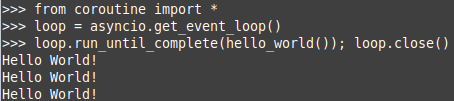

In [83]:
# asyncio, async / await; PEP 492 Python3.5
import asyncio

async def hello_world():
    while True:
        print("Hello World!")
        await asyncio.sleep(1.0)

loop = asyncio.get_event_loop()
loop.run_until_complete(hello_world())
loop.close()

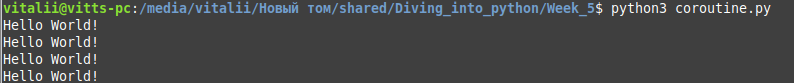

In [ ]:
# asyncio, tcp сервер
import asyncio

async def handle_echo(reader, writer):
    data = await reader.read(1024)
    message = data.decode()
    addr = writer.get_extra_info("peername")
    print("received %r from %r" % (message, addr))
    writer.close()

loop = asyncio.get_event_loop()
coro = asyncio.start_server(handle_echo, "127.0.0.1", 10001, loop=loop)
server = loop.run_until_complete(coro)

try:
    loop.run_forever()
except KeyboardInterrupt:
    pass
server.close()
loop.run_until_complete(server.wait_closed())
loop.close()

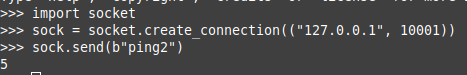
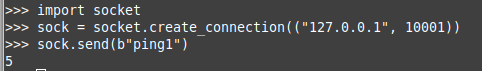
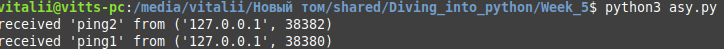

In [ ]:
# asyncio, tcp клиент
import asyncio

async def tcp_echo_client(message, loop):
    reader, writer = await asyncio.open_connection("127.0.0.1",10001, loop=loop)
    print("send: %r" % message)
    writer.write(message.encode())
    writer.close()

loop = asyncio.get_event_loop()
message = "hello World!"
loop.run_until_complete(tcp_echo_client(message, loop))
loop.close()

## Работа с asyncio

In [ ]:
### asyncio.Future, аналог concurrent.futures.Future
import asyncio

async def slow_operation(future):
    await asyncio.sleep(1)
    future.set_result("Future is done!")

loop = asyncio.get_event_loop()
future = asyncio.Future()
asyncio.ensure_future(slow_operation(future))

loop.run_until_complete(future)
print(future.result())
loop.close()

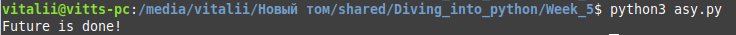

In [ ]:
### asyncio.Task, запуск нескольких корутин
import asyncio

async def sleep_task(num):
    for i in range(5):
        print(f"process task: {num} iter: {i}")
        await asyncio.sleep(1)
    return num

# ensure_future or create_task
loop = asyncio.get_event_loop()

task_list = [loop.create_task(sleep_task(i)) for i in range(2)]
#loop.run_until_complete(asyncio.gather(sleep_task(10), sleep_task(20)))

loop.run_until_complete(asyncio.wait(task_list))

loop.close()

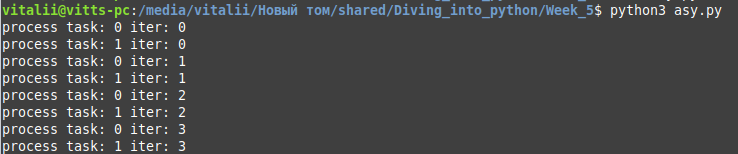

In [ ]:
# loop.run_in_executor, запуск в отдельном потоке

import asyncio
from urllib.request import urlopen

# a synchronous function
def sync_get_url(url):
    return urlopen(url).read()

async def load_url(url, loop=None):
    future = loop.run_in_executor(None, sync_get_url, url)
    response = await future
    print(len(response))

loop = asyncio.get_event_loop()
loop.run_until_complete(load_url("https://google.com", loop=loop))

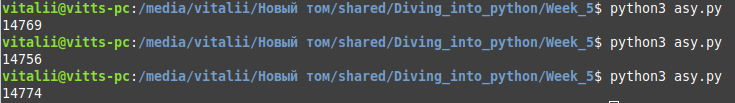